# Importing the libraries

In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

C:\Users\Divyojyoti Sinha\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import sys 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import numpy as np
import os
import sys
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "C:\\Data_Science\\Data_science\\CAPP\\"
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Reading the Image Data

In [3]:
DIR = "C:\\Data_Science\\Data_science\\CAPP\\data\\natural_images\\combined\\"
sz=224

In [4]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['airplane']:
                label = 0
            elif nextDir in ['car']:
                label = 1
            else:
                label = 2

                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file, 0)
                if img is not None:
                    #img = np.frombuffer(img, dtype=np.uint8).astype(np.float32)
                    img = skimage.transform.resize(img, (128, 128), mode='constant')
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    #img = img.reshape(-1)
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [5]:
df_X, df_Y = get_data(DIR)

100%|███████████████████████████████████████████████████████████████████████████████| 788/788 [00:05<00:00, 133.82it/s]


In [6]:
print(df_X.shape,'\n',df_Y.shape)

(2483, 128, 128) 
 (2483,)


# Train - Test Split

In [7]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_labels,test_labels = train_test_split(df_X,
                                                             df_Y,
                                                             test_size=0.2,
                                                             random_state=13)

In [8]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (1986, 128, 128)
Test set (images) shape: (497, 128, 128)


In [9]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'C',
 2: 'M'
}

Text(0.5,1,'(Label: M)')

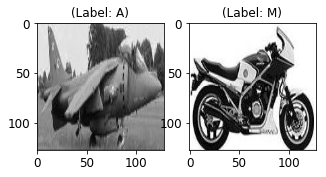

In [10]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (128, 128))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (128, 128))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Data Preprocessing

The images of the dataset are grayscale images with pixel values ranging from 0 to 255 with a dimension of 64 x 64, so before it is fed into the model, it is very important to preprocess it. We first need to convert each 64 x 64 image of train and test set into a matrix of size 64 x 64 x 1, which can be fed into the network:

In [11]:
train_data = train_data.reshape(-1, 128, 128, 1)
test_data = test_data.reshape(-1, 128, 128, 1)
train_data.shape, test_data.shape

((1986, 128, 128, 1), (497, 128, 128, 1))

Now, we need to make sure to check the data type of the training and testing NumPy arrays, it should be in float32 format, if not we will need to convert it into this format. 

In [12]:
train_data.dtype, test_data.dtype

(dtype('float64'), dtype('float64'))

In [13]:
train_data = train_data.astype(np.float32)
train_data.dtype

dtype('float32')

In [14]:
test_data = test_data.astype(np.float32)
test_data.dtype

dtype('float32')

We also need to make sure that the pixel values have been rescaled in range 0 - 1 inclusive.

In [15]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

## Partitioning the data into train - validation sets

It's important to partition the data. In order for our model to generalize well, we need to split the training data into two parts: a training and a validation set. We will need to train our model on 80% of the data and validate it on 20% of the remaining training data.

This will also help us in reducing the chances of overfitting, as we will be validating our model on data it would not have seen in the training phase.

The train_test_split module of scikit-learn can be used to divide the data properly:

In [16]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_labels,
                                                             test_size=0.2,
                                                             random_state=13)

# Building Convolutional Autoencoder

The images are of size 128 x 128 x 1 or a 4096-dimensional vector. We need to convert the image matrix to an array, rescale it between 0 and 1, reshape it so that it's of size 128 x 128 x 1, and feed this as an input to the network.

Also, we are using a batch size of 128 using a higher batch size of 256 or 512 is also preferable it all depends on the system. It contributes heavily in determining the learning parameters and affects the prediction accuracy.

In [17]:
batch_size = 128
epochs = 200
inChannel = 1
x, y = 128, 128
input_img = Input(shape = (x, y, inChannel))
num_classes = 3

In [35]:
def encoder(input_img):
    #encoder
    #input = 128 x 128 x 1 (wide and thin)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) #128 x 128 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #64 x 64 x 32
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1) #64 x 64 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #32 x 32 x 64
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) #32 x 32 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 128 x 128 x 1
    return decoded

In [36]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [37]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 16)      160       
_________________________________________________________________
batch_normalization_15 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_16 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 32)        4640      
__________

In [38]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,
                                    epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 1588 samples, validate on 398 samples
Epoch 1/200
1588/1588 [==============================] - ETA: 1:06 - loss: 0.149 - ETA: 33s - loss: 0.146 - ETA: 22s - loss: 0.16 - ETA: 16s - loss: 0.14 - ETA: 12s - loss: 0.13 - ETA: 9s - loss: 0.1241 - ETA: 7s - loss: 0.115 - ETA: 5s - loss: 0.108 - ETA: 4s - loss: 0.101 - ETA: 2s - loss: 0.095 - ETA: 1s - loss: 0.089 - ETA: 0s - loss: 0.084 - 16s 10ms/step - loss: 0.0826 - val_loss: 0.0540
Epoch 2/200
1588/1588 [==============================] - ETA: 6s - loss: 0.025 - ETA: 6s - loss: 0.024 - ETA: 5s - loss: 0.024 - ETA: 4s - loss: 0.023 - ETA: 4s - loss: 0.023 - ETA: 3s - loss: 0.024 - ETA: 3s - loss: 0.024 - ETA: 2s - loss: 0.024 - ETA: 1s - loss: 0.024 - ETA: 1s - loss: 0.023 - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.023 - 8s 5ms/step - loss: 0.0231 - val_loss: 0.0377
Epoch 3/200
1588/1588 [==============================] - ETA: 6s - loss: 0.023 - ETA: 6s - loss: 0.024 - ETA: 5s - loss: 0.023 - ETA: 4s - loss: 0.022 - ETA: 4s - lo

Epoch 42/200
1588/1588 [==============================] - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 8s 5ms/step - loss: 0.0046 - val_loss: 0.0105
Epoch 43/200
1588/1588 [==============================] - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 2s - loss: 0.004 - ETA: 1s - loss: 0.004 - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.004 - 8s 5ms/step - loss: 0.0044 - val_loss: 0.0125
Epoch 44/200
1588/1588 [==============================] - ETA: 6s - loss: 0.005 - ETA: 6s - loss: 0.005 - ETA: 5s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 4s - loss: 0.005 - ETA: 3s - loss: 0.004 - ETA: 3s - loss

Epoch 63/200
1588/1588 [==============================] - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 8s 5ms/step - loss: 0.0037 - val_loss: 0.0069
Epoch 64/200
1588/1588 [==============================] - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 8s 5ms/step - loss: 0.0037 - val_loss: 0.0089
Epoch 65/200
1588/1588 [==============================] - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss

Epoch 84/200
1588/1588 [==============================] - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 8s 5ms/step - loss: 0.0031 - val_loss: 0.0074
Epoch 85/200
1588/1588 [==============================] - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 8s 5ms/step - loss: 0.0034 - val_loss: 0.0065
Epoch 86/200
1588/1588 [==============================] - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss

Epoch 105/200
1588/1588 [==============================] - ETA: 6s - loss: 0.003 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 8s 5ms/step - loss: 0.0029 - val_loss: 0.0048
Epoch 106/200
1588/1588 [==============================] - ETA: 6s - loss: 0.004 - ETA: 6s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 1s - loss: 0.003 - ETA: 0s - loss: 0.003 - ETA: 0s - loss: 0.003 - 8s 5ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 107/200
1588/1588 [==============================] - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - l

Epoch 146/200
1588/1588 [==============================] - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 8s 5ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 147/200
1588/1588 [==============================] - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 8s 5ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 148/200
1588/1588 [==============================] - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - l

Epoch 187/200
1588/1588 [==============================] - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 5s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 8s 5ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 188/200
1588/1588 [==============================] - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.002 - ETA: 5s - loss: 0.001 - ETA: 4s - loss: 0.001 - ETA: 4s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 2s - loss: 0.002 - ETA: 1s - loss: 0.002 - ETA: 0s - loss: 0.002 - ETA: 0s - loss: 0.002 - 8s 5ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 189/200
1588/1588 [==============================] - ETA: 6s - loss: 0.002 - ETA: 6s - loss: 0.001 - ETA: 5s - loss: 0.001 - ETA: 4s - loss: 0.002 - ETA: 4s - loss: 0.002 - ETA: 3s - loss: 0.002 - ETA: 3s - l

In [40]:
autoencoder.save('autoencoder_128_32_200.h5')

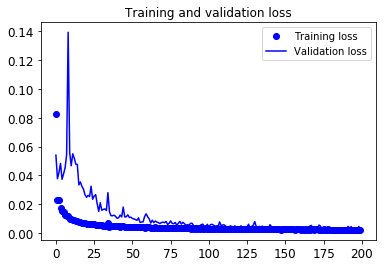

In [39]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
from keras.models import load_model

In [19]:
autoencoder = load_model('autoencoder_128_32_200.h5')

In [20]:
restored_imgs  = autoencoder.predict(valid_X)

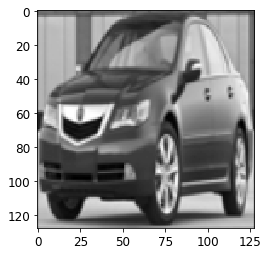

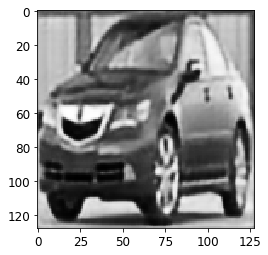

----------------------------


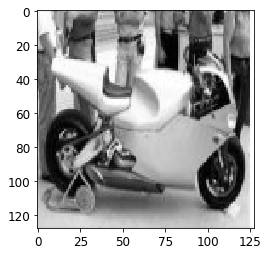

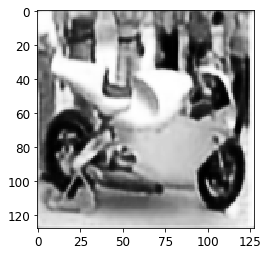

----------------------------


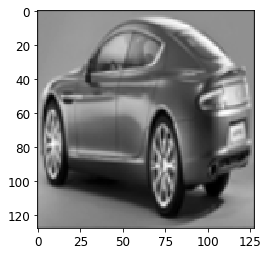

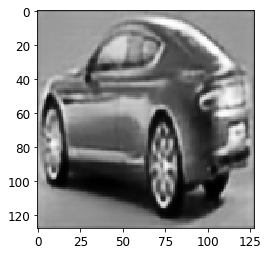

----------------------------


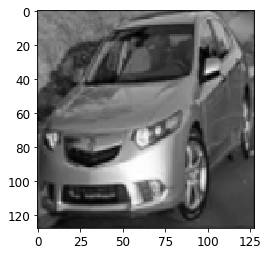

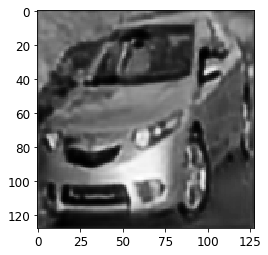

----------------------------


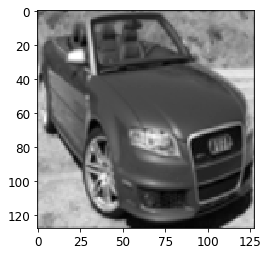

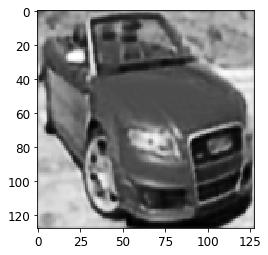

----------------------------


In [21]:
for i in range(5):
    plt.imshow(valid_X[i].reshape(128, 128))
    plt.gray()
    plt.show()
    
    plt.imshow(restored_imgs[i].reshape(128, 128))
    plt.gray()
    plt.show()
    
    print("----------------------------")

In [22]:
layers = len(autoencoder.layers)

for i in range(layers):
    print(i, ". ", autoencoder.layers[i].output.get_shape())

0 .  (?, 128, 128, 1)
1 .  (?, 128, 128, 16)
2 .  (?, 128, 128, 16)
3 .  (?, 128, 128, 16)
4 .  (?, 128, 128, 16)
5 .  (?, 64, 64, 16)
6 .  (?, 64, 64, 32)
7 .  (?, 64, 64, 32)
8 .  (?, 64, 64, 32)
9 .  (?, 64, 64, 32)
10 .  (?, 32, 32, 32)
11 .  (?, 32, 32, 64)
12 .  (?, 32, 32, 64)
13 .  (?, 32, 32, 64)
14 .  (?, 32, 32, 64)
15 .  (?, 32, 32, 128)
16 .  (?, 32, 32, 128)
17 .  (?, 32, 32, 128)
18 .  (?, 32, 32, 128)
19 .  (?, 32, 32, 64)
20 .  (?, 32, 32, 64)
21 .  (?, 32, 32, 64)
22 .  (?, 32, 32, 64)
23 .  (?, 32, 32, 32)
24 .  (?, 32, 32, 32)
25 .  (?, 32, 32, 32)
26 .  (?, 32, 32, 32)
27 .  (?, 64, 64, 32)
28 .  (?, 64, 64, 16)
29 .  (?, 64, 64, 16)
30 .  (?, 64, 64, 16)
31 .  (?, 64, 64, 16)
32 .  (?, 128, 128, 16)
33 .  (?, 128, 128, 1)


In [23]:
#layer[26] is compressed representation
get_3rd_layer_output = K.function([autoencoder.layers[0].input], [autoencoder.layers[26].output])
compressed = get_3rd_layer_output([valid_X])[0]

In [24]:
compressed.shape

(398, 32, 32, 32)

In [25]:
#layer[26] is size of (None, 16, 16, 64). this means 64 different 16 x 16 sized matrixes. We will flatten these matrixes.
compressed = compressed.reshape(398,32*32*32)

In [47]:
from tensorflow.contrib.factorization.python.ops import clustering_ops
import tensorflow as tf

In [63]:
unsupervised_model = tf.contrib.learn.KMeansClustering(
    3 #num of clusters
    , distance_metric = clustering_ops.COSINE_DISTANCE
    , initial_clusters=tf.contrib.learn.KMeansClustering.RANDOM_INIT
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000024A684D7D68>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\DIVYOJ~1\\AppData\\Local\\Temp\\tmpy_c_s79h'}


In [64]:
def train_input_fn():
    data = tf.constant(compressed, tf.float32)
    return (data, None)

In [65]:
unsupervised_model.fit(input_fn=train_input_fn, steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\DIVYOJ~1\AppData\Local\Temp\tmpy_c_s79h\model.ckpt.
INFO:tensorflow:loss = 342.41016, step = 1
INFO:tensorflow:global_step/sec: 6.89028
INFO:tensorflow:loss = 243.5522, step = 101 (14.513 sec)
INFO:tensorflow:global_step/sec: 18.738
INFO:tensorflow:loss = 243.50946, step = 201 (5.337 sec)
INFO:tensorflow:global_step/sec: 19.0586
INFO:tensorflow:loss = 243.49283, step = 301 (5.246 sec)
INFO:tensorflow:global_step/sec: 18.7171
INFO:tensorflow:loss = 243.48701, step = 401 (5.344 sec)
INFO:tensorflow:global_step/sec: 19.0478
INFO:tensorflow:loss = 243.47807, step = 501 (5.250 sec)
INFO:tensorflow:global_step/sec: 19.3641
INFO:tensorflow:loss = 243.46635, step = 601 (5.164 sec)
INFO:tensorflow:global_step/sec: 19.3268
INFO:tensorflow:loss = 243.45139, step = 701 (5.174 sec)
I

KMeansClustering(params={'num_clusters': 3, 'training_initial_clusters': 'random', 'distance_metric': 'cosine', 'random_seed': 0, 'use_mini_batch': True, 'mini_batch_steps_per_iteration': 1, 'kmeans_plus_plus_num_retries': 2, 'relative_tolerance': None})

In [66]:
clusters = unsupervised_model.predict(input_fn=train_input_fn)



INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\DIVYOJ~1\AppData\Local\Temp\tmpy_c_s79h\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [70]:
unsupervised_model.CLUSTERS.count

<function str.count>

In [78]:
index = 0
c_0_count = 0
c_1_count = 0
c_2_count = 0

mis_classified = 0
corr_classified = 0


for i in clusters:
    
    current_cluster = i['cluster_idx']
    features = valid_X[index]
    
    
    if current_cluster == 0:
            if valid_ground[index] == current_cluster:
                corr_classified += 1
            else:
                mis_classified += 1
            c_0_count += 1
            
    if current_cluster == 1:
            if valid_ground[index] == current_cluster:
                corr_classified += 1
            else:
                mis_classified += 1
            c_1_count += 1
            
    if current_cluster == 2:
            if valid_ground[index] == current_cluster:
                corr_classified += 1
            else:
                mis_classified += 1
            c_2_count += 1
            
            

            
    index = index + 1

## Accuracy using tensorflow-clustering

In [79]:
accuracy = corr_classified/len(valid_X)
accuracy

0.30904522613065327

### using simple kmeans

In [26]:
from sklearn.cluster import KMeans


In [29]:
k = KMeans(n_clusters=3, n_jobs=-1, random_state=728)
# Let's do some timings to see how long it takes to train.
# Train it up
y_pred = k.fit_predict(compressed)

In [31]:
y_pred.shape

(398,)

In [32]:
valid_ground.shape

(398,)

In [34]:
from sklearn.metrics import accuracy_score

In [35]:
acc = np.round(accuracy_score(valid_ground, y_pred), 5)
acc

0.33668

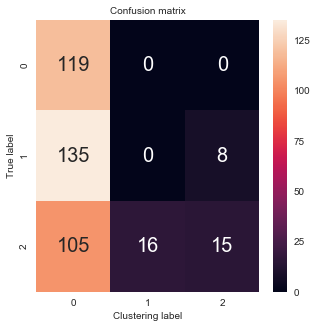

In [39]:

import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=1)
confusion_matrix = sklearn.metrics.confusion_matrix(valid_ground, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=10)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Clustering label', fontsize=10)
plt.show()